# Simulation of Ising Model

We have a network $G = (V, E)$. Each vertex $x$ has a spin $\sigma_x \in \{-1, +1\}$. 

The probability of the system being in a state $\sigma = (\sigma_x)_x$  is

$$ \pi(\sigma) = \frac{\exp(-\beta H(\sigma))}{Z} $$

where $H$ is the hamiltonian of the system defined by $$H(\sigma) = -J\sum_{(x, y)\in E}{\sigma_x \sigma_y} - B\sum_{x}{\sigma_x } $$

In the case of ferromagnetism, we chose $B=0$.

Hence, the conditional probabilities are given by :

$$ \pi(\sigma_x \mid \sigma_y, y \in \mathcal{N}(x)) \propto \exp\left(\beta J\sum_{y\sim x}{\sigma_x \sigma_y}\right)  $$

We know the probability measure up to a multiplicative constant. Hence, we can use Metropolis-Hasting algorithm inside a Gibbs sampler.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
n = 256
S = np.random.uniform(0, 1 , size=(n, n))
p = .5
S = 1*(S>=p) - (S<p)

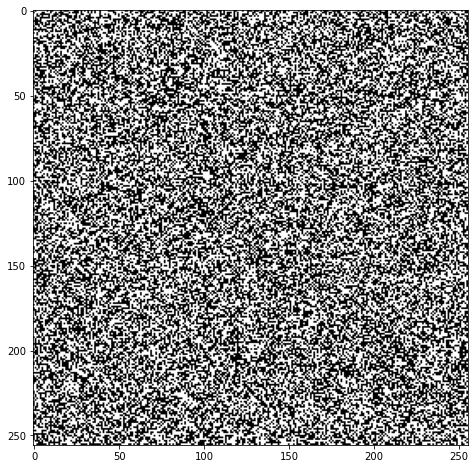

In [3]:
fig=plt.figure(figsize=(8, 8))
plt.imshow(S,  cmap="gray")
plt.show()

In [4]:
@jit(nopython=True)
def logsumexp(x) :
    c = np.max(x)
    y = x-c
    return c + np.log(np.sum(np.exp(y)))

In [5]:
@jit(nopython=True)
def log_pi(x, sx, S, T) :
    N, _ = np.shape(S)
    i, j = x
    neighbors = [((i-1)%N, j%N), (i%N, (j-1)%N), (i%N, (j+1)%N), ((i+1)%N, j%N)]
    P = 0
    for (k,l) in neighbors : 
        P += sx*S[k, l]/T

    return P

In [8]:
@jit(nopython=True)
def simul(x, S, T) :
    p = log_pi(x, 1, S, T)
    q = log_pi(x, -1, S, T)
    lse = logsumexp(np.array([p, q]))
    p = np.exp(p - lse)
    q = np.exp(q - lse)
    z = p+q
    p/=z
    u = np.random.uniform(0, 1)
    if u<=p :
        return 1
    else : 
        return -1

In [9]:
@jit(nopython=True)
def ising_model(S, T, n_iter) :
    new_S = np.copy(S)
    N, _ = np.shape(S)
    for _ in range(n_iter) :
        for i in range(N) :
            for j in range(N) :
                sx = simul((i,j), new_S, T)
                new_S[i,j] = sx

    return new_S 

In [10]:
test = ising_model(S, T=1e-2, n_iter=100) # T<0 => anti-ferromagnetism

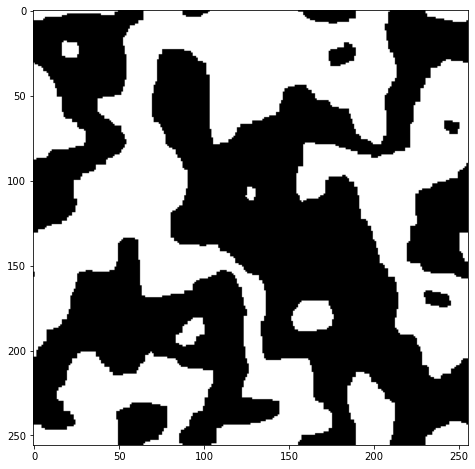

In [11]:
fig = plt.figure(figsize=(8,8))
plt.imshow(test, cmap="gray")
plt.show()

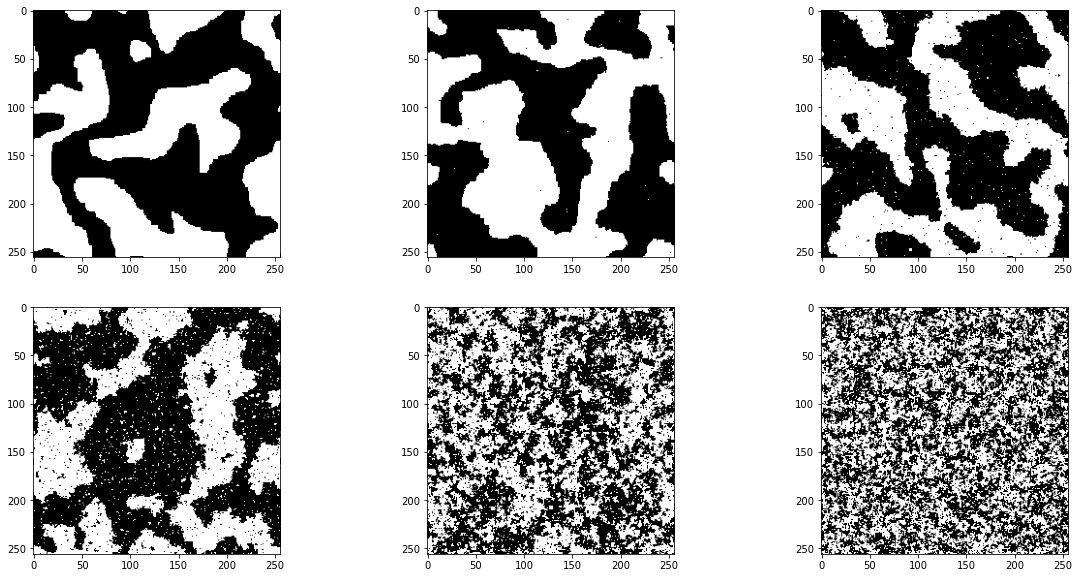

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
Ts = np.array([[0.01, 1, 1.5], 
                 [2, 2.5, 3]])
for i in [0, 1] :
    for j in [0, 1, 2] :
        ax[i, j].imshow(ising_model(S, T=Ts[i, j], n_iter=200), cmap="gray")

plt.show()